In [1]:
%env CUDA_VISIBLE_DEVICES=0
from es_map import qdax_task

import numpy as np
import brax
#from brax import jumpy as jp
from brax.envs import env
import jax.numpy as jnp
import jax

from brax.envs import wrappers


env: CUDA_VISIBLE_DEVICES=0


In [2]:
from brax import jumpy as jp

In [3]:
key = jax.random.PRNGKey(777)
key_envs = jax.random.split(key, 1)

In [4]:
from es_map.qdax_envs.unidirectional_envs import ant, walker, hopper, halfcheetah, humanoid
ant.QDUniAnt

es_map.qdax_envs.unidirectional_envs.ant.QDUniAnt

In [5]:
environment = "ant"  # @param ['ant', 'halfcheetah', 'hopper', 'humanoid', 'reacher', 'walker2d', 'fetch', 'grasp', 'ur5e']
env = envs.create(env_name=environment)
state = env.reset(rng=jp.random_prngkey(seed=0))

NameError: name 'envs' is not defined

In [20]:
env = ant.QDUniAnt()

In [7]:
state = env.reset(key)

In [10]:
obs = env.reset()
action = jnp.array(np.random.randn(*env.action_space.shape))
obs,reward,done,info = env.step(action)


In [19]:
env._state.qp.pos[:,0,0:2]

DeviceArray([[-5.3280688e-05,  1.0067961e-05],
             [ 2.0433247e-02, -1.5636818e-02],
             [ 1.5331312e-03,  2.6831359e-03],
             ...,
             [ 9.7237397e-03,  1.9296104e-02],
             [ 6.5357529e-04, -1.6677615e-03],
             [ 1.2993325e-02, -4.0642726e-03]], dtype=float32)

In [25]:
#env.reset()
#env._state.info

In [37]:
a = jax.random.normal(key,[8])

def jax_es_create_population(parent_params,key,popsize,eval_batch_size,sigma):
    
    half_popsize = int(popsize/2)
    if 2*half_popsize != popsize:
        raise "error, popsize must be divisible by 2"
    
    # copy params to gpu, if not there already
    parent_params = jnp.array(parent_params)
    
    perturbations = jax.random.normal(key,[half_popsize, parent_params.shape[0]])
    
    # mirrored sampling
    perturbations = jnp.concatenate([perturbations, -1 * perturbations])
    child_params = parent_params + sigma * perturbations
    
    parent_eval_params = jnp.repeat(parent_params.reshape(1,-1),eval_batch_size,axis=0)
    all_params = jnp.concatenate([child_params,parent_eval_params],axis=0)

    return all_params,perturbations

all_params,perturbations = jax_es_create_population(a,key,popsize=4,eval_batch_size=2,sigma=1.0)

In [28]:
a = jnp.array(np.arange(10)).reshape(1,-1)
jnp.repeat(a,4,axis=0)

DeviceArray([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
             [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
             [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
             [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]], dtype=int32)

In [32]:
#from brax.envs import ant

In [20]:
action_space = env.action_space

In [27]:
orig_env  = ant.QDUniAnt()

In [54]:
batch_size = 10

env = ant.QDUniAnt()
env = wrappers.EpisodeWrapper(env, episode_length=1000, action_repeat=1)
env = wrappers.VectorWrapper(env, batch_size=batch_size)
env = wrappers.AutoResetWrapper(env)
env = wrappers.VectorGymWrapper(env)
env


VectorGymWrapper(10)

In [57]:
env._env

In [29]:
obs = env.reset()
action = jnp.array(np.random.randn(*env.action_space.shape))
obs,reward,done,info = env.step(action)

In [ ]:
env._state.qp.pos[:,0]

In [62]:
from IPython.display import HTML, clear_output
from brax.io import html
HTML(html.render(orig_env.unwrapped, [single_state.qp]))

AttributeError: 'QDUniAnt' object has no attribute 'config'

In [32]:
single_env_qp = 

(10, 10, 3)

In [73]:
run_path = "/scratch/ak1774/runs/large_files_jax/run-20220303_085708-pk4loduh"
import json
with open(run_path+'/config.json') as f:
    config = json.load(f)
theta = np.load(run_path+"/theta.npy")
from es_map import jax_evaluate
env = jax_evaluate.create_env(config["env_name"],1,1,1000)
model = jax_evaluate.create_MLP_model(env.observation_space.shape[1],env.action_space.shape[1])

model_params = model.init(key)
vec,shapes,indicies = jax_evaluate.params_tree_to_vec(model_params)   # now we can do anything with vec, like get mutated copies, calculate weighted sums for ES gradient...
# reconstructed_model_params = vec_to_params_tree(vec,shapes,indicies)
params = jax_evaluate.vec_to_params_tree(jnp.array(theta),shapes,indicies)

from brax import envs
env_fn = envs.create_fn(env_name=env_name)
orig_env = env_fn()

jit_env_reset = jax.jit(orig_env.reset)
jit_env_step = jax.jit(orig_env.step)
jit_inference_fn = jax.jit(model.apply)

# do a rollout, with policy
rollout = []
rng = jax.random.PRNGKey(seed=0)
state = orig_env.reset(rng=rng)
for i in range(300):
    print(i)
    
    rollout.append(state)
    act_rng, rng = jax.random.split(rng)
    act = jit_inference_fn(params, state.obs, act_rng)
    state = jit_env_step(state, act)

    
    #rollout.append(state)
    #act_rng, rng = jax.random.split(rng)
    #act = model.apply(params, state.obs)
    #state = orig_env.step(state, act)




0


TypeError: __call__() takes 2 positional arguments but 3 were given

In [72]:
HTML(html.render(orig_env.sys, [s.qp for s in rollout]))

In [43]:
def get_state_of_single(state,i):
    single_qp = env._state.qp.replace(ang=state.qp.ang[i],pos=state.qp.pos[i], rot=state.qp.rot[i], vel=state.qp.vel[i])
    single_state = state.replace(qp=single_qp, obs=env._state.obs[i], reward=env._state.reward[i], done=env._state.done[i])
    return single_state

In [44]:
single_state = get_state_of_single(env._state,0)

In [42]:
env._state.qp.

DeviceArray([[ -2.9722981 ,   0.5370713 ,  -1.3422078 ],
             [ -0.25793624,  -1.4036578 ,   5.8827424 ],
             [  3.6104767 ,  -4.4154706 ,   6.740587  ],
             [ -3.2364454 ,   0.52683085, -12.770712  ],
             [  4.5631127 ,   4.132759  , -14.566703  ],
             [ -2.6985877 ,   0.7522205 ,  11.89936   ],
             [  4.073015  ,  -3.4758124 ,  13.271248  ],
             [ -3.1361234 ,   0.8718652 ,  -3.4634967 ],
             [ -0.38211715,   3.3213189 ,  -3.985687  ],
             [  0.        ,   0.        ,   0.        ]], dtype=float32)

In [48]:
from brax import envs
env_name = "ant"  # @param ['ant', 'humanoid', 'fetch', 'grasp', 'halfcheetah', 'ur5e', 'reacher']
env_fn = envs.create_fn(env_name=env_name)
env = env_fn()
state = env.reset(rng=jp.random_prngkey(seed=0))

HTML(html.render(env.sys, [state.qp]))

In [ ]:
def params_tree_to_vec(params):
    
    numelements = jax.tree_map(lambda x:x.size ,params)
    numel_leafs,treedef = jax.tree_flatten(numelements)
    ending_indicies = np.cumsum(numel_leafs)
    ending_indicies_tree = jax.tree_unflatten(treedef,ending_indicies)
    
    shapes_tree = jax.tree_map(lambda x:x.shape ,params)
    
    flat_shaped_tree = jax.tree_map(lambda x:x.reshape(-1) ,params)
    flat_shaped_leafs,treedef = jax.tree_flatten(flat_shaped_tree)
    
    vec = jnp.concatenate(flat_shaped_leafs)
    
    return vec,shapes_tree,ending_indicies_tree
    
def vec_to_params_tree(vec,shapes,indicies):
    return jax.tree_multimap(lambda i,shape:vec[i-np.prod(shape):i].reshape(shape),indicies,shapes)

batch_vec_to_params = jax.vmap(vec_to_params_tree,in_axes=[0, None,None])


In [177]:
def create_ant(population_size,evaluation_batch_size):
    env = ant.QDUniAnt()
    env = wrappers.EpisodeWrapper(env, episode_length=1000, action_repeat=1)
    env = wrappers.VectorWrapper(env, batch_size=population_size+evaluation_batch_size)
    env = wrappers.AutoResetWrapper(env)
    env = wrappers.VectorGymWrapper(env)
    return env

def create_model(observation_size, action_size):
    parametric_action_distribution = distribution.NormalTanhDistribution(event_size=action_size)
    return = networks.make_model(
      [64, 64, parametric_action_distribution.param_size],
      observation_size,
    )
    
batch_model_apply = jp.vmap(model.apply)
initial_params_tree = model.init(key)
    
initial_params_flat = 
    
    


In [136]:
def calculate_obs_stats(obs_stats):
    sum = obs_stats["sum"]
    sumsq = obs_stats["sumsq"]
    count = obs_stats["count"]
    
    if count == 0:
        return np.zeros_like(sum),np.ones_like(sum)
    mean = sum / count
    std = np.sqrt(np.maximum(sumsq / count - np.square(mean), 1e-2))
    return mean,std


In [181]:
def rollout_episodes(env,params,obs_stats,config):
    
    obs = env.reset()
    
    # TODO model from params
    
    cumulative_reward = jnp.zeros(obs.shape[0])
    active_episode = jnp.ones_like(cumulative_reward)
    bd_dim = env._state.info["bd"].shape[1]
    bds = jnp.zeros([obs.shape[0],bd_dim])

    # prepare obs stats
    mean,var = calculate_obs_stats(obs_stats)
    mean = jnp.array(mean)
    var = jnp.array(var)
    
    # also prepare variable to accumulate values to calcuate obs stats, we will add new obs and return these
    obs_sums = jnp.array(obs_stats["sum"])
    obs_squared_sums = jnp.array(obs_stats["sumsq"])
    obs_count = jnp.array([obs_stats["count"]])
    
    
    # max_steps = config[""] # TODO
    max_steps = 1000
    
    
    
    for step_i in range(max_steps):
    
        normalized_obs = (obs-mean) / var
        
        # TODO apply model with normalized_obs
        action = jnp.array(np.random.randn(*env.action_space.shape))
    
        obs,reward,done,info = env.step(action)
        
        
        last_step_of_first_episode = active_episode * done # will only ever be 1 when we are at last step of first episode
        active_episode = active_episode * (1 - done) # once the first episode is done, active_episode will become and stay 0
        
        cumulative_reward += reward * active_episode
    
        # bs is sometimes nan and inf (we multiply by 0 in those cases, but still infects with nan...)
        info_bd = jnp.nan_to_num(info["bd"],nan=0.0, posinf=0.0, neginf=0.0)
        bds = bds + last_step_of_first_episode.reshape(-1,1) * info_bd

        # record observation stats, only count active episodes (zero out others)
        active_obs = active_episode.reshape(-1,1) * obs
        obs_sums = obs_sums + jnp.sum(active_obs,axis=0)
        obs_squared_sums = obs_squared_sums + jnp.sum(active_obs*active_obs,axis=0)
        obs_count = obs_count + jnp.sum(active_episode)
    
    # turn back obs stats into normal cpu format
    new_obs_stats = {
        "sum" : np.array(obs_sums),
        "sumsq" : np.array(obs_squared_sums),
        "count" : obs_count[0],
    }
    return cumulative_reward,bds,new_obs_stats
    
    

In [138]:
observation_stats = {                  # this is a single obs stats to keep track of during the whole experiment. 
        "sum" : np.zeros(obs_shape),       # This is always expanded, and always used to calculate the current mean and std
        "sumsq" : np.zeros(obs_shape),
        "count" : 0,
    }

In [143]:
env = create_ant(1)

In [145]:
%%time
fitness,bds,new_obs_stats = rollout_episodes(env,params=None,obs_stats=observation_stats,config=None)

CPU times: user 4.4 s, sys: 989 ms, total: 5.39 s
Wall time: 3.59 s


In [146]:
env = create_ant(100)

In [148]:
%%time
fitness,bds,new_obs_stats = rollout_episodes(env,params=None,obs_stats=observation_stats,config=None)

CPU times: user 4.61 s, sys: 942 ms, total: 5.56 s
Wall time: 3.8 s


In [178]:
env = create_ant(1000)

In [151]:
%%time
fitness,bds,new_obs_stats = rollout_episodes(env,params=None,obs_stats=observation_stats,config=None)

CPU times: user 5.04 s, sys: 819 ms, total: 5.86 s
Wall time: 4.1 s


In [165]:
env = create_ant(5000)

In [167]:
%%time
fitness,bds,new_obs_stats = rollout_episodes(env,params=None,obs_stats=observation_stats,config=None)

CPU times: user 5.57 s, sys: 680 ms, total: 6.25 s
Wall time: 4.8 s


In [182]:
env = create_ant(10000)

In [184]:
%%time
fitness,bds,new_obs_stats = rollout_episodes(env,params=None,obs_stats=observation_stats,config=None)

CPU times: user 674 ms, sys: 68.3 ms, total: 743 ms
Wall time: 620 ms


In [169]:
env = create_ant(20000)

In [171]:
%%time
fitness,bds,new_obs_stats = rollout_episodes(env,params=None,obs_stats=observation_stats,config=None)

CPU times: user 8.81 s, sys: 463 ms, total: 9.27 s
Wall time: 10.1 s


In [155]:
env = create_ant(50000)

In [157]:
%%time
fitness,bds,new_obs_stats = rollout_episodes(env,params=None,obs_stats=observation_stats,config=None)

CPU times: user 21 s, sys: 444 ms, total: 21.5 s
Wall time: 34.5 s


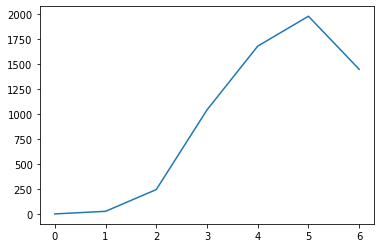

In [172]:
import matplotlib.pyplot as plt
episodes = np.array([1,100,1000,5000,10000,20000,50000])
runtimes = np.array([3.59,3.8,4.1,4.8,5.95,10.1,34.5])

episode_per_sec = episodes / runtimes
step_per_sec = 1000*episode_per_sec

plt.plot(episode_per_sec)

In [ ]:
def create_model_forward_fn(vec_to_params_fn,model_params_flat,obs):
    
    w1 = 
    

In [12]:
from brax.training import distribution, networks

def _generate_individual_model(observation_size, action_size):
    parametric_action_distribution = distribution.NormalTanhDistribution(event_size=action_size)
    return networks.make_model(
      [64, 64, parametric_action_distribution.param_size],
      observation_size,
    )

model = _generate_individual_model(30,4)

In [12]:
model_params_dict = model.init(key)

In [38]:
model.apply(model_params_dict,)
policy_model.apply(params, obs)

TypeError: apply() missing 1 required positional argument: 'variables'

In [6]:
obs = env.reset()

In [14]:
model = _generate_individual_model(env.observation_space.shape[1],env.action_space.shape[1])
params = model.init(key)

In [15]:
model_out = model.apply(params,obs)

In [17]:
def get_deterministic_actions(model_out):
    loc, scale = jnp.split(model_out, 2, axis=-1) # splits it into 2 even subarrays along last axis
    act = jnp.tanh(loc)
    return act

In [18]:
action = get_deterministic_actions(model_out)

In [17]:
def params_tree_to_vec(params):
    
    numelements = jax.tree_map(lambda x:x.size ,params)
    numel_leafs,treedef = jax.tree_flatten(numelements)
    ending_indicies = np.cumsum(numel_leafs)
    ending_indicies_tree = jax.tree_unflatten(treedef,ending_indicies)
    
    shapes_tree = jax.tree_map(lambda x:x.shape ,params)
    
    flat_shaped_tree = jax.tree_map(lambda x:x.reshape(-1) ,params)
    flat_shaped_leafs,treedef = jax.tree_flatten(flat_shaped_tree)
    
    vec = jnp.concatenate(flat_shaped_leafs)
    
    return vec,shapes_tree,ending_indicies_tree
    
def vec_to_params_tree(vec,shapes,indicies):
    return jax.tree_multimap(lambda i,shape:vec[i-np.prod(shape):i].reshape(shape),indicies,shapes)

In [18]:
vec,shapes_tree,ending_indicies_tree = params_tree_to_vec(model_params_dict)

In [23]:
reconstructed = vec_to_params_tree(vec,shapes_tree,ending_indicies_tree)

In [28]:
noise = jax.random.normal(key,shape=[100,vec.size])
mutated_params = vec + noise * 0.02

In [31]:
batch_vec_to_params = jax.vmap(vec_to_params_tree,in_axes=[0, None,None])
policy_trees = batch_vec_to_params(mutated_params,shapes_tree,ending_indicies_tree)

In [29]:
mutated_params.shape

(100, 6664)

In [57]:
obs_batch = jax.random.normal(key,shape=[100,30])
#logits = model.apply(policy_trees,obs_batch)

batch_apply = jp.vmap(model.apply)

#def apply_model(policy_model, params, obs):
#    return policy_model.apply(params, obs)

#batch_apply = jax.vmap(
#    lambda *args: apply_model(*args),
#    in_axes=(None, 0, 0),
#    out_axes=0,
#  )



In [48]:
flat_dict,treedef = jax.tree_flatten(policy_trees)
for val in flat_dict:
    print(val.shape)

(100, 64)
(100, 30, 64)
(100, 64)
(100, 64, 64)
(100, 8)
(100, 64, 8)


In [59]:
logits = batch_apply(policy_trees,obs_batch)

In [62]:
logits.shape

(100, 8)

In [125]:
%%time

obs = env.reset()

dones = []
rewards = []
bds = []

#jitted_step = jax.jit(env.step)


obs_shape = env.observation_space.shape[1:]  # first dim is the batch dimension

obs_sums = jnp.zeros(obs_shape)
obs_squared_sums = jnp.zeros(obs_shape)
obs_count = jnp.zeros([1])


cumulative_reward = jnp.zeros(obs.shape[0])
active_episode = jnp.ones_like(cumulative_reward)
bd_dim = 4
bds = jnp.zeros([obs.shape[0],bd_dim])

all_bds = []

mean,var = calculate_obs_mean_var(obs_sums,obs_squared_sums,obs_count)

for i in range(1000):
    # calulate action 
    action = jnp.array(np.random.randn(*env.action_space.shape))
    
    #action = jp.zeros(env.action_space.shape)
    obs,reward,done,info = env.step(action)
    #obs,reward,done,info = jitted_step(action)  # The jitted version sets bd to inf for some reason
    
    # done will only turn to 1 for one step, afterwards, it then starts a new episode which we complately ignore 
    last_step_of_first_episode = active_episode * done # will only ever be 1 when we are at last step of first episode
    active_episode = active_episode * (1 - done) # once the first episode is done, active_episode will become ans stay 0

    normalized_obs = (obs-mean) / var
    
    # record observation stats, only count active episodes (zero out others)
    active_obs = active_episode.reshape(-1,1) * obs
    obs_sums = obs_sums + jnp.sum(active_obs,axis=0)
    obs_squared_sums = obs_squared_sums + jnp.sum(active_obs*active_obs,axis=0)
    obs_count = obs_count + jnp.sum(active_episode)
    
    #print(i,jnp.sum(last_step_of_first_episode))
    
    cumulative_reward += reward * active_episode
    
    # bs is sometimes nan and inf
    # normaly we dont care about this, because we multiply with 0 in these cases, but the nan infects the calulation
    info_bd = jnp.nan_to_num(info["bd"],nan=0.0, posinf=0.0, neginf=0.0)
    bds = bds + last_step_of_first_episode.reshape(-1,1) * info_bd
    #all_bds.append(bds[0])
    #all_bds.append(info["bd"][0])

# return fitness,bd and obs stats


CPU times: user 6.91 s, sys: 446 ms, total: 7.36 s
Wall time: 6.02 s


In [133]:
obs = env.reset()
env._state.info["bd"].shape[1]


4

In [104]:
obs.shape

(10000, 87)

In [126]:
mean,var = calculate_obs_mean_var(obs_sums,obs_squared_sums,obs_count)
mean

array([ 5.94160497e-01,  4.32981789e-01, -1.16435648e-03,  4.14690759e-04,
        1.55369285e-03,  7.64215220e-05,  8.55309248e-01,  1.43447047e-04,
       -8.55417311e-01, -6.60346181e-04, -8.55582118e-01,  1.10520145e-04,
        8.54979992e-01,  2.13483837e-03, -1.25741775e-04,  5.36825173e-02,
        5.20938425e-04, -2.79176980e-04,  5.75903617e-03,  9.60683974e-04,
       -1.82338953e-02,  7.42486562e-04,  1.63782630e-02,  1.58866504e-04,
        1.88048501e-02,  4.87847487e-04, -1.94809884e-02,  1.80268427e-04,
        1.63626115e-04,  8.27212036e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.53560320e-02,  2.55756211e-02,  1.96347997e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -2.48626862e-02,
        2.52265353e-02,  1.95395634e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -2.50827465e-02, -2.56742444e-02,  1.95342168e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.52132099e-02,
       -2.58367639e-02,  

In [94]:
np.array(jnp.sum(active_episode)).reshape(-1)[0]

0.0

In [19]:
obs = env.reset()
action = jp.zeros(env.action_space.shape)
obs,reward,done,info = env.step(action)
obs,reward,done,info = env.step(action)
obs,reward,done,info = env.step(action)
obs,reward,done,info = env.step(action)
obs,reward,done,info = env.step(action)
#obs,reward,done,info = jitted_step(action)
#obs,reward,done,info = jitted_step(action)
#obs,reward,done,info = jitted_step(action)
#obs,reward,done,info = jitted_step(action)
#obs,reward,done,info = jitted_step(action)

In [25]:
last_step_of_first_episode.shape

(10000,)

In [26]:
info["bd"].shape

(10000, 4)

In [37]:
(last_step_of_first_episode.reshape(-1,1) * info["bd"]).shape

(10000, 4)

In [54]:
env.observation_space.shape[1:]

(87,)

In [200]:
env._state.info["bd"]

(52, 4)

In [100]:
key = jax.random.PRNGKey(777)
key_envs = jax.random.split(key, 1)
first_state = task.reset_fn_batch(key_envs)

In [76]:
policy_model = task.policy_model

In [17]:
type(policy_model)

brax.training.networks.FeedForwardModel

In [18]:
policy_params = policy_model.init(key)

In [ ]:
def params_tree_to_vec(params):
    
    numelements = jax.tree_map(lambda x:x.size ,params)
    numel_leafs,treedef = jax.tree_flatten(numelements)
    ending_indicies = np.cumsum(numel_leafs)
    ending_indicies_tree = jax.tree_unflatten(treedef,ending_indicies)
    
    shapes_tree = jax.tree_map(lambda x:x.shape ,params)
    
    flat_shaped_tree = jax.tree_map(lambda x:x.reshape(-1) ,policy_params)
    flat_shaped_leafs,treedef = jax.tree_flatten(flat_shaped_tree)
    
    vec = jnp.concatenate(flat_shaped_leafs)
    
    return vec,shapes_tree,ending_indicies_tree
    
def vec_to_params_tree(vec,shapes,indicies):
    return jax.tree_multimap(lambda i,shape:vec[i-np.prod(shape):i].reshape(shape),indicies,shapes)

In [ ]:
evaluation_task_fn = task.eval

prun_es_eval = jax.pmap(evaluation_task_fn, in_axes=(0, 0, None))
eval_scores, obs, state, done, bd,reward_trajectory = prun_es_eval(training_state.state,
                                                                   pparams_device,
                                                                   key)

In [220]:
pparams = task.get_random_parameters(100,key)

In [224]:
vmap_eval = jax.vmap(task.eval)

In [227]:
#results = vmap_eval(first_state,pparams,key,in_axes=(0, 0, None))

In [93]:
task.reset_fn

<CompiledFunction of <bound method AutoResetWrapper.reset of <brax.envs.wrappers.AutoResetWrapper object at 0x7f9c7c169fd0>>>

In [127]:
# flatten, unflatten
#leafs,treedef = jax.tree_flatten(policy_params)
def create_a(tt):
    def a():
        num_vars = len(jax.tree_leaves(policy_params))
        treedef = jax.tree_structure(policy_params)
        all_keys = jax.random.split(key, num=num_vars)
        key_tree = jax.tree_unflatten(treedef, all_keys)
        results = []
        for i in range(tt):
             results.append(jax.tree_multimap(lambda k,x: jax.random.normal(k, shape=x.shape, dtype=x.dtype),key_tree,policy_params))
        # construct population
        #noise = jax.tree_map(lambda x: jax.random.normal(k, shape=x.shape, dtype=x.dtype))

        return results
    return jax.jit(a)
    
#leafs


In [146]:
numel_leafs,_ = jax.tree_flatten(numels)
indicies = np.cumsum(numel_leafs)
indicies
#jnp.cumsum(numel_leafs)

[64, 5568, 64, 4096, 16, 1024]

In [186]:

# we start with a single theta
policy_vec,shapes,indicies = params_tree_to_vec(policy_params)

noise = jax.random.normal(key,shape=[100,policy_vec.size])
mutated_params = policy_vec + noise * 0.02

# then we evaluate mutated params


# than we calculate the weights
weights = jax.random.normal(key,shape=[100,])

updated_params = 



In [179]:
def params_tree_to_vec(params):
    
    numelements = jax.tree_map(lambda x:x.size ,params)
    numel_leafs,treedef = jax.tree_flatten(numelements)
    ending_indicies = np.cumsum(numel_leafs)
    ending_indicies_tree = jax.tree_unflatten(treedef,ending_indicies)
    
    shapes_tree = jax.tree_map(lambda x:x.shape ,params)
    
    flat_shaped_tree = jax.tree_map(lambda x:x.reshape(-1) ,policy_params)
    flat_shaped_leafs,treedef = jax.tree_flatten(flat_shaped_tree)
    
    vec = jnp.concatenate(flat_shaped_leafs)
    
    return vec,shapes_tree,ending_indicies_tree
    
def vec_to_params_tree(vec,shapes,indicies):
    return jax.tree_multimap(lambda i,shape:vec[i-np.prod(shape):i].reshape(shape),indicies,shapes)
    
    

In [207]:
batch_vec_to_params = jax.vmap(vec_to_params_tree,in_axes=[0, None,None])
policy_trees = batch_vec_to_params(mutated_params,shapes,indicies)

In [180]:
vec,shapes,indicies = params_tree_to_vec(policy_params)
vec

DeviceArray([ 0.        ,  0.        ,  0.        , ...,  0.20398107,
             -0.20045444, -0.00977703], dtype=float32)

In [181]:
reconstructed_params = vec_to_params_tree(vec,shapes,indicies)
reconstructed_params

FrozenDict({
    params: {
        hidden_0: {
            bias: DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                         0., 0., 0., 0.], dtype=float32),
            kernel: DeviceArray([[ 0.06186872, -0.09058239,  0.14539498, ..., -0.13792196,
                          -0.10169195,  0.02787265],
                         [-0.04083425, -0.06141775,  0.04246718, ..., -0.16937312,
                           0.02928372, -0.08244027],
                         [ 0.08485675, -0.05951697,  0.16626488, ..., -0.13909711,
                           0.15142804, -0.01380209],
                         ...,
                         [-0.01254437, -0.08890191,  0.02675493, ...,  0.07982638,
                    

In [157]:
#def params_tree_to_1d_array(params):

numelements = jax.tree_map(lambda x:x.size ,policy_params)
numel_leafs,treedef = jax.tree_flatten(numelements)
ending_indicies = np.cumsum(numel_leafs)

flat_shaped_tree = jax.tree_map(lambda x:x.reshape(-1) ,policy_params)
flat_shaped_leafs,treedef = jax.tree_flatten(flat_shaped_tree)

#reconstructed_tree = jax.tree_unflatten(treedef,)


#    leafs,treedef = jax.tree_flatten(params)
    
#    1d_array = jnp.stack(leafs)
    
    
#    return flat_vec,treedef


    

In [163]:
ending_indicies_tree = jax.tree_unflatten(treedef,ending_indicies)
ending_indicies_tree

FrozenDict({
    params: {
        hidden_0: {
            bias: 64,
            kernel: 5632,
        },
        hidden_1: {
            bias: 5696,
            kernel: 9792,
        },
        hidden_2: {
            bias: 9808,
            kernel: 10832,
        },
    },
})

In [129]:
leafs,treedef = jax.tree_flatten(policy_params)
leafs

[DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0.], dtype=float32),
 DeviceArray([[ 0.06186872, -0.09058239,  0.14539498, ..., -0.13792196,
               -0.10169195,  0.02787265],
              [-0.04083425, -0.06141775,  0.04246718, ..., -0.16937312,
                0.02928372, -0.08244027],
              [ 0.08485675, -0.05951697,  0.16626488, ..., -0.13909711,
                0.15142804, -0.01380209],
              ...,
              [-0.01254437, -0.08890191,  0.02675493, ...,  0.07982638,
               -0.06672598,  0.08014732],
              [ 0.07237192, -0.03387853,  0.11414871, ...,  0.07441101,
               -0.06219068,  0.04540798],
              [-0.17531773,  0.14242597, -0.03727367, ...,  0.143593

In [ ]:
jax.tree_multimap(lambda g, n: g + n * mutation_power, pparams, noise)

In [103]:
policy_params = policy_model.init(key)
theta = policy_params


In [ ]:
noise = jax.tree_multimap(
        lambda g, k: jax.random.normal(k, shape=g.shape, dtype=g.dtype), theta,
        jax.tree_unflatten(treedef, all_keys))

In [ ]:


 _eval_and_add,
    local_devices_to_use,
    task.eval,
    population_size,
    task.get_bd,
    jax.jit(repertoire.add_to_archive),
    
def _eval_and_add(local_devices_to_use,
                  evaluation_task_fn = task.eval,
                  population_size,
                  get_bd_fn=task.get_bd,
                  add_to_archive_fn,
                  training_state: TrainingState,
                  pparams,
                  key):
    

In [58]:
# task.eval needs 3 parameters: state, params,key
task.eval

functools.partial(<function BraxTask._eval at 0x7fa0009d9430>, FeedForwardModel(init=<function make_model.<locals>.<lambda> at 0x7f9fe3a47b80>, apply=<bound method Module.apply of MLP(
    # attributes
    layer_sizes = [64, 64, 16]
    activation = silu
    kernel_init = init
    activate_final = False
    bias = True
)>), <CompiledFunction of <bound method AutoResetWrapper.reset of <brax.envs.wrappers.AutoResetWrapper object at 0x7f9fe4a863d0>>>, <CompiledFunction of <bound method AutoResetWrapper.step of <brax.envs.wrappers.AutoResetWrapper object at 0x7f9fe4a863d0>>>, 1000, 1)

In [9]:
#results = task.eval(first_state,policy_params,key)

In [54]:
key = jax.random.PRNGKey(seed=6)
noise = jax.random.normal(key, shape=(10000,100000))
weights = jax.random.normal(key, shape=(10000,))

In [55]:
%%time
results = jnp.matmul(weights,noise).block_until_ready()

CPU times: user 4.73 ms, sys: 4.74 ms, total: 9.47 ms
Wall time: 7.82 ms


In [56]:
%%time
np_noise = np.array(noise)
np_weights = np.array(weights)

CPU times: user 1.57 s, sys: 2.53 s, total: 4.11 s
Wall time: 4.1 s


In [57]:
%%time
results = np.matmul(np_weights,np_noise)

CPU times: user 5.28 s, sys: 597 ms, total: 5.88 s
Wall time: 96.3 ms


In [52]:
noise = jax.random.normal(key, shape=(100,100000))

In [53]:
%%time
np_noise = np.array(noise)

CPU times: user 26 ms, sys: 25.7 ms, total: 51.7 ms
Wall time: 50 ms


In [ ]:
# I dont want to do everything on JAX
# I want to have a jax function which takes a parent parameter, and applies mutations, returns noise and mutated parameters
# I want a function which takes 1 step in the env, which will return the state, weather each env is done, the reward, the obs, and the bd
# Then i want to have a function which takek all the trajectory and caluclates

In [ ]:
# The for loop for the episode is a normal python loop.


In [1]:
%env CUDA_VISIBLE_DEVICES=0

import functools
import time

from IPython.display import HTML, Image 
import gym

import brax

from brax import envs
from brax import jumpy as jp
from brax.envs import to_torch
from brax.io import html
from brax.io import image
import jax
from jax import numpy as jnp
import torch
v = torch.ones(1, device='cuda')  # init torch cuda before jax

env: CUDA_VISIBLE_DEVICES=0


In [65]:
from es_map import qdax_task

In [140]:
entry_point = functools.partial(envs.create_gym_env, env_name='ant')
#entry_point = functools.partial(qdax_task.BraxTask.generate_env,env_name='ant')
if 'brax-ant-v0' not in gym.envs.registry.env_specs:
    gym.register('brax-ant-v0', entry_point=entry_point)

gym_env = gym.make("brax-ant-v0", batch_size=4096)

# wrap it to interoperate with torch data structures
#gym_env = to_torch.JaxToTorchWrapper(gym_env, device='cuda')

# jit compile env.reset
obs = gym_env.reset()

# jit compile env.step
#action = torch.rand(gym_env.action_space.shape, device='cuda') * 2 - 1
#obs, reward, done, info = gym_env.step(action)

In [143]:
gym_env._state.done.shape

(4096,)

In [152]:
gym_env._env.batch_size

4096

In [163]:
def get_foot_contact(env,state):
    sys_info = env.sys.info(state.qp)
    contact = jp.sum(jp.square(jp.clip(sys_info.contact.vel, -1, 1)), axis=1) != 0
    foot_contacts = contacts[2:-1:2] # BD is only for the contact of the foot and the floor
    return foot_contacts

b_get_foot_contact = jax.vmap(get_foot_contact,in_axes=[None, 0])
#res = b_get_foot_contact(gym_env._env,gym_env._state)

In [8]:
#batch_info = jp.vmap(gym_env._env.sys.info)
#infos = batch_info(gym_env._state.qp)

In [ ]:
infos

In [97]:
environment = "ant"  # @param ['ant', 'halfcheetah', 'hopper', 'humanoid', 'reacher', 'walker2d', 'fetch', 'grasp', 'ur5e']
env = envs.create(env_name=environment)
state = env.reset(rng=jp.random_prngkey(seed=0))

In [117]:
action = jp.ones((env.action_size,))
state = env.step(state,action)

In [114]:
# get obs
sys_info = env.sys.info(state.qp)
env.unwrapped._get_obs(state.qp,sys_info)

# get bd
contact = jp.sum(jp.square(jp.clip(sys_info.contact.vel, -1, 1)), axis=1) != 0
foot_contacts = contacts[2:-1:2] # BD is only for the contact of the foot and the floor


In [123]:
def my_reset(env,key):
    state = env.reset(rng=jp.random_prngkey(seed=0))
    
    # get bd
    sys_info = env.sys.info(state.qp)
    contact = jp.sum(jp.square(jp.clip(sys_info.contact.vel, -1, 1)), axis=1) != 0
    foot_contacts = contacts[2:-1:2] # BD is only for the contact of the foot and the floor
    
    return state,foot_contacts

def my_step(env,state,action):
    state = env.step(state,action)
    
    # get bd
    sys_info = env.sys.info(state.qp)
    contact = jp.sum(jp.square(jp.clip(sys_info.contact.vel, -1, 1)), axis=1) != 0
    foot_contacts = contacts[2:-1:2] # BD is only for the contact of the foot and the floor
    
    return state,foot_contacts
    

In [125]:
key = jp.random_prngkey(seed=0)
keys = 
state,foot_contacts = my_reset(env,key)
action = jp.ones((env.action_size,))
state,foot_contacts = my_step(env,state,action)

In [132]:
batched_jitted_reset = jax.vmap(jax.jit(my_reset),in_axes=[None, 0])
batched_jitted_step = jax.vmap(jax.jit(my_step),in_axes=[None, 0,0])

batched_reset = jax.vmap(my_reset,in_axes=[None, 0])
batched_step = jax.vmap(my_step,in_axes=[None, 0,0])

In [7]:
#keys = jax.random.split(key, num=10)
#states,foot_contacts = batched_reset(env,keys)
#actions = jp.ones((10,env.action_size))
#states,foot_contacts = batched_step(env,states,actions)

In [121]:
state.obs.shape

(87,)

In [46]:
def ant_get_foot_contacts(sys_info):
    contact = jp.sum(jp.square(jp.clip(sys_info.contact.vel, -1, 1)), axis=1) != 0
    foot_contacts = contacts[2:-1:2] # BD is only for the contact of the foot and the floor
    return foot_contacts

def qd_reset(env_reset_fn,key):
    state = env_reset_fn(key)
    foot_contacts = ant_get_foot_contacts()

def qd_step(env_step_fn):
    pass
    

In [48]:
contacts = get_contacts(sys_info)
foot_contacts = contacts[2:-1:2] # BD is only for the contact of the foot and the floor

In [49]:
foot_contacts

array([False, False,  True, False])

In [54]:
env

In [83]:
fitnesses = np.random.randn(10000)
jnp_fitnesses = jnp.array(fitnesses)

In [98]:
%%time
sorted_indicies = jnp.argsort(jnp_fitnesses)

CPU times: user 0 ns, sys: 948 µs, total: 948 µs
Wall time: 506 µs


In [99]:
%%time

all_ranks = jnp.linspace(-0.5,0.5,sorted_indicies.size) 
perturbation_ranks = jnp.zeros(sorted_indicies.size)
perturbation_ranks = perturbation_ranks.at[sorted_indicies].set(all_ranks)



CPU times: user 5.2 ms, sys: 691 µs, total: 5.89 ms
Wall time: 3.92 ms


In [94]:
%%time
sorted_indicies = np.argsort(fitnesses)

CPU times: user 1.31 ms, sys: 1.44 ms, total: 2.76 ms
Wall time: 2.28 ms


In [95]:
%%time
all_ranks = np.linspace(-0.5,0.5,len(sorted_indicies)) 
perturbation_ranks = np.zeros(len(sorted_indicies))
perturbation_ranks[sorted_indicies] = all_ranks

#perturbation_ranks = np.array(perturbation_ranks)


CPU times: user 1.11 ms, sys: 0 ns, total: 1.11 ms
Wall time: 788 µs
